In [1]:
import scipy.io
import numpy as np
from bmm import BMM
import pandas as pd
from lda import LDA
import matplotlib.pyplot as plt
import tqdm

data = scipy.io.loadmat('kos_doc_data.mat')

# Qa

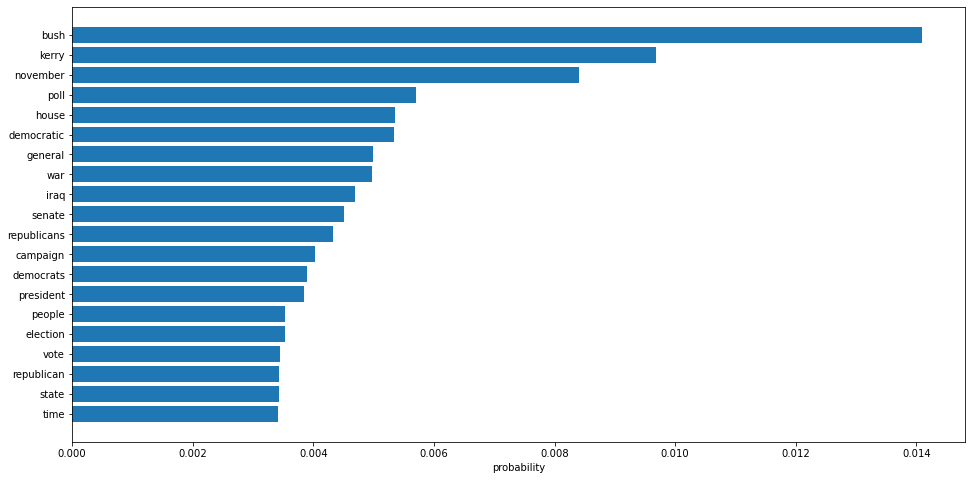

In [2]:
A = np.array(data['A'])
B = data['B']
V = np.array([i[0][0] for i in data['V']])
W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
words_id = 1 + np.arange(W)
word_counts = np.zeros(len(words_id))
for word_id in words_id:
    word_counts[word_id - 1] = np.sum(A[np.where(A[:, 1] == word_id), 2])
probs = word_counts / np.sum(word_counts)
largest_id = np.argsort(probs)[-20:]
largest_prob_words = V[largest_id]
largest_probs = probs[largest_id]

plt.figure(figsize=(16, 8))
plt.barh(largest_prob_words, largest_probs)
plt.xlabel('probability')
plt.savefig('plots/a.jpg')

In [3]:
missing_words = V[np.where(probs == 0.)]
print(missing_words)

['alhusainy' 'amdt' 'amphibians' 'bulb' 'cats' 'dearborn' 'giago'
 'liebeck' 'mcdonalds' 'sahni' 'schwarz' 'specialist' 'splice' 'stella']


## 1. Largest log-prob of test set: log(0.0140972), where the test set only includes a word 'bush'; 2. Smallest log-prob of test set: -oo, where words like 'cats', 'giago' and 'stella' are included.

# Qb
1. For MLE, $p(x^*=m|w)\approx \hat{\beta}_m = \frac{c_m}{N}$
2. For Bayesian, $p(x^*=m|w)=\int p(x^*=m|w, \beta)p(\beta|w)d\beta = \int \beta_m Dir(\beta|\alpha+c)d\beta=\mathbf{E}_{Dir(\beta|\alpha+c)}[\beta_m]=\frac{\alpha_m+c_m}{\sum_j\alpha_j+c_j}=\frac{c_m + \alpha_m}{N+\sum_j\alpha_j}$

And thus, for:
1. small $\alpha$: probability of rare words would be slightly raised up from 0, while that of common words would be moved down for a little bit
2. large $\alpha$: The predictive probability would be donimated by the $\alpha$s, resulting that the words would be considered uniformly sampled from $M$ categories.

2697.1068182222075
2683.9840703508485
3703.385309861396
6725.573382732053


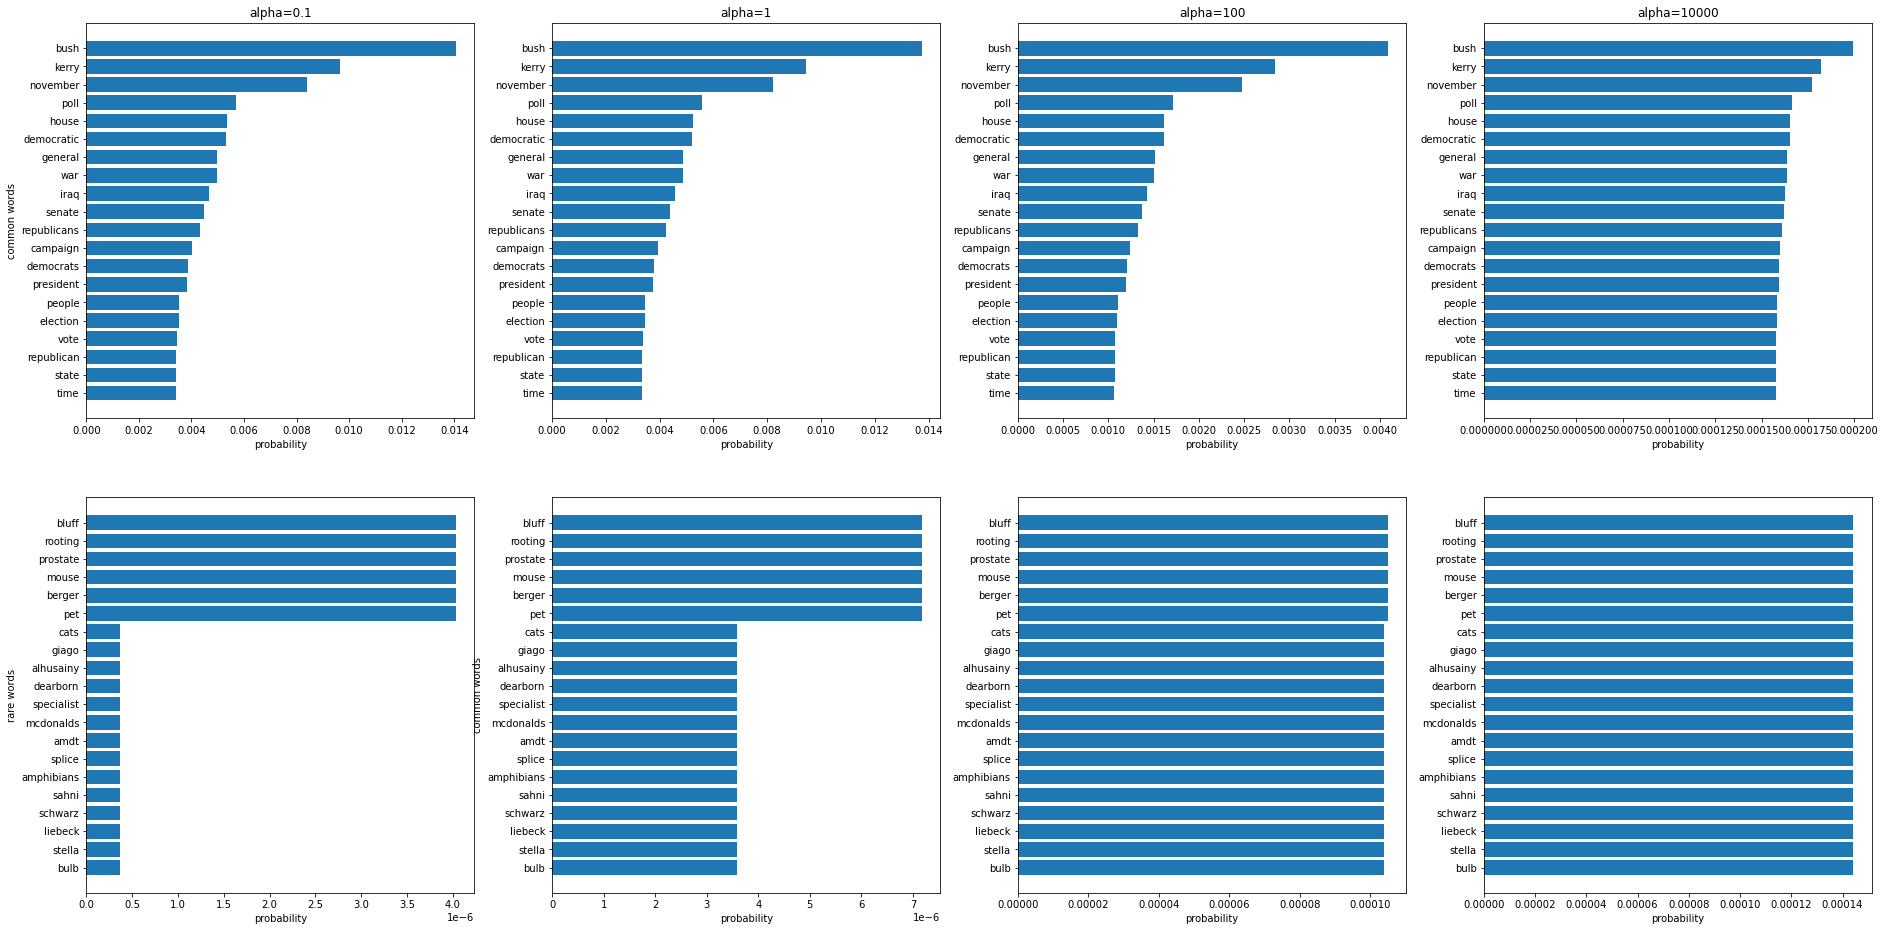

In [18]:
def bayesian_inf(word_counts, alpha, k=20, last=True):
    tmp = word_counts + alpha
    post_probs = tmp / np.sum(tmp)
    if last:
        ind = np.argsort(post_probs)[-20:]
    else:
        ind = np.argsort(post_probs)[:20]
        B_id = np.unique(B[:, 0])
        log_lkh = 0
        for i in B_id:
            log_lkh_doc, _ = prob_and_perplex(i, post_probs)
            log_lkh += log_lkh_doc
        perplexity = np.exp(-log_lkh / np.sum(B[:, 2]))
        print(perplexity)
    plt.barh(V[ind], post_probs[ind])
    plt.xlabel('probability')

plt.figure(figsize=(32, 16))
plt.subplot(2, 4, 1)
plt.title('alpha={}'.format(.1))
plt.ylabel('common words')
bayesian_inf(word_counts, 0.1)
plt.subplot(2, 4, 2)
plt.title('alpha={}'.format(1))
bayesian_inf(word_counts, 1)
plt.subplot(2, 4, 3)
plt.title('alpha={}'.format(100))
bayesian_inf(word_counts, 100)
plt.subplot(2, 4, 4)
plt.title('alpha={}'.format(10000))
bayesian_inf(word_counts, 10000)

plt.subplot(2, 4, 5)
plt.ylabel('rare words')
bayesian_inf(word_counts, .1, last=False)
plt.subplot(2, 4, 6)
plt.ylabel('common words')
bayesian_inf(word_counts, 1, last=False)
plt.subplot(2, 4, 7)
bayesian_inf(word_counts, 100, last=False)
plt.subplot(2, 4, 8)
bayesian_inf(word_counts, 10000, last=False)
plt.savefig('plots/b.jpg')

# Qc

log-likelihood and perplexity for 2001 document in test data

we compute the log-probability using categorical distribution function, because we observe the whole document where the words are in order. To conveniate the computing, we use bag of words(group the words and count them).

In [16]:
alpha = 1
tmp = word_counts + alpha
post_probs = tmp / np.sum(tmp)

def prob_and_perplex(doc_id, probs):
    doc = B[np.where(B[:, 0] == doc_id)]
    N = np.sum(doc[:, 2])
    log_lkh = np.sum(doc[:, 2] * np.log(probs[doc[:, 1] - 1]))
    perplexity = np.exp(-log_lkh / N)
    return log_lkh, perplexity

log_lkh, perplexity = prob_and_perplex(2001, post_probs)
print('log-probability:{:.2f}; perplexity: {:.2f}'.format(log_lkh, perplexity))

log-probability:-3688.62; perplexity: 4373.11


perplexity for all documents in test data

In [23]:
B_id = np.unique(B[:, 0])
log_lkh = 0
pers = np.zeros_like(B_id)
for j, i in enumerate(B_id):
    log_lkh_doc, pers[j] = prob_and_perplex(i, post_probs)
    log_lkh += log_lkh_doc
perplexity = np.exp(-log_lkh / np.sum(B[:, 2]))
print('All Docs: log-probability:{:.2f}; perplexity: {:.2f}'.format(log_lkh, perplexity))

All Docs: log-probability:-1545978.59; perplexity: 2683.98


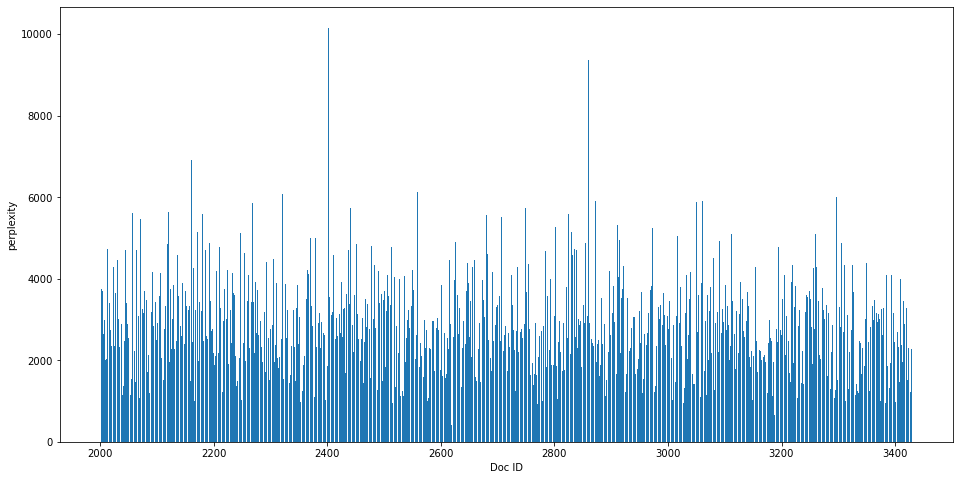

In [25]:
plt.figure(figsize=(16, 8))
plt.bar(B_id, pers)
plt.xlabel('Doc ID')
plt.ylabel('perplexity')
plt.savefig('plots/c.jpg')

In [7]:
missing_id = np.vectorize(lambda x: np.where(V == x)[0][0])(missing_words) + 1
DOC_2001 = B[np.where(B[:, 0] == 2001)]
print('MISSING WORDS', missing_words)
print('DOC 2001', np.vectorize(lambda x: np.sum(DOC_2001[:, 1] == x))(missing_id))
print('ALL DOCs', np.vectorize(lambda x: np.sum(B[:, 1] == x))(missing_id))

MISSING WORDS ['alhusainy' 'amdt' 'amphibians' 'bulb' 'cats' 'dearborn' 'giago'
 'liebeck' 'mcdonalds' 'sahni' 'schwarz' 'specialist' 'splice' 'stella']
DOC 2001 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ALL DOCs [1 1 1 4 3 1 2 2 2 2 2 7 1 2]


1. Q: Why perplexities are different(one doc v.s. all docs)? A: Because the distribution of words are different in different documents. And the perplexity of all docs just averaging the distribution over documents. Notice that, some documents contain missing words in training data, thus resuling that the log-probability is very small.
2. Q: What's the perplexity for uniform-multinomial? A: $perplexity=\exp (-\frac{1}{n}\log p(w_1,...,w_n|\pi)) = \exp (-\frac{1}{n}\log (\frac{1}{M})^{n})=M$

# Qd

In [29]:
np.random.seed(1)
# A = np.array(data['A'])
# B = data['B']
VV = data['V']
K = 20  # number of clusters
alpha = 1  # parameter of the Dirichlet over mixture components
gamma = .1  # parameter of the Dirichlet over words
perplexity_bbm, swk_bbm, posteriors_bbm, swks_bbm = BMM(A, B, K, alpha, gamma, seed=1)
# print(perplexity)
# I = 20
# indices = np.argsort(-swk, axis=0)
# indices = indices[:20, :]
# top_words = VV[indices]
# for topic in top_words[:, :, 0].T:
#     print('\n')
#     for word in topic:
#         print(word[0])

In [30]:
perplexity_bbm

2091.976819337592

perplexity: 2091.98
Stationary distribution:
p(z=1)=0.07
p(z=2)=0.03
p(z=3)=0.01
p(z=4)=0.18
p(z=5)=0.00
p(z=6)=0.02
p(z=7)=0.05
p(z=8)=0.01
p(z=9)=0.29
p(z=10)=0.00
p(z=11)=0.03
p(z=12)=0.01
p(z=13)=0.00
p(z=14)=0.01
p(z=15)=0.00
p(z=16)=0.05
p(z=17)=0.00
p(z=18)=0.13
p(z=19)=0.09
p(z=20)=0.01


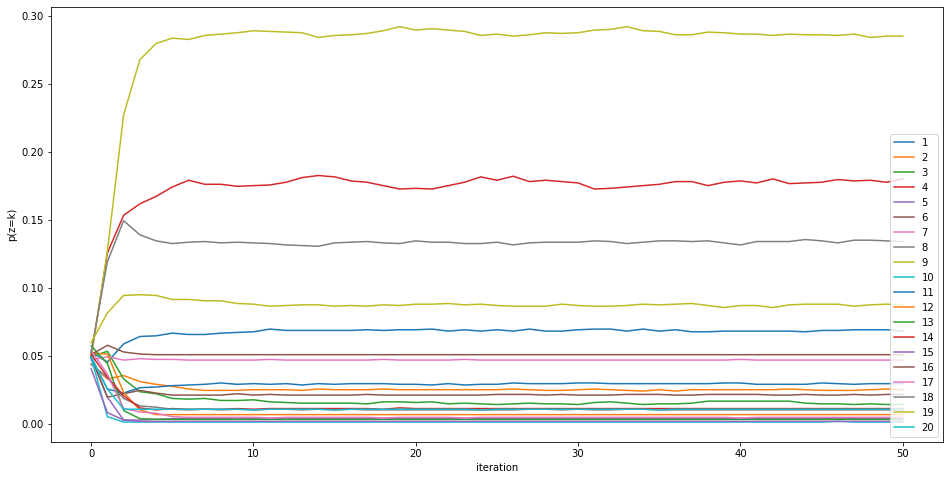

In [33]:
alpha = 1
gamma = .1
posterior_counts_bbm = np.vstack(posteriors_bbm) + alpha
posterior_probs_bbm = []
plt.figure(figsize=(16, 8))
for j in range(51):
    posterior_probs_bbm.append(posterior_counts_bbm[j, :] / np.sum(posterior_counts_bbm[j, :]))
posterior_probs_bbm = np.vstack(posterior_probs_bbm)
for i in range(K):
    plt.plot(np.arange(51), posterior_probs_bbm[:, i])
plt.legend(np.arange(K) + 1, loc=4)
plt.xlabel('iteration')
plt.ylabel('p(z=k)')
print('perplexity: {:.2f}'.format(perplexity_bbm))
print('Stationary distribution:')
for i in range(K):
    print('p(z={})={:.2f}'.format(i + 1, posterior_probs_bbm[-1, i]))
plt.savefig('plots/d1.jpg')

2091.976819337592
2110.6234449041117
2108.6407215140907


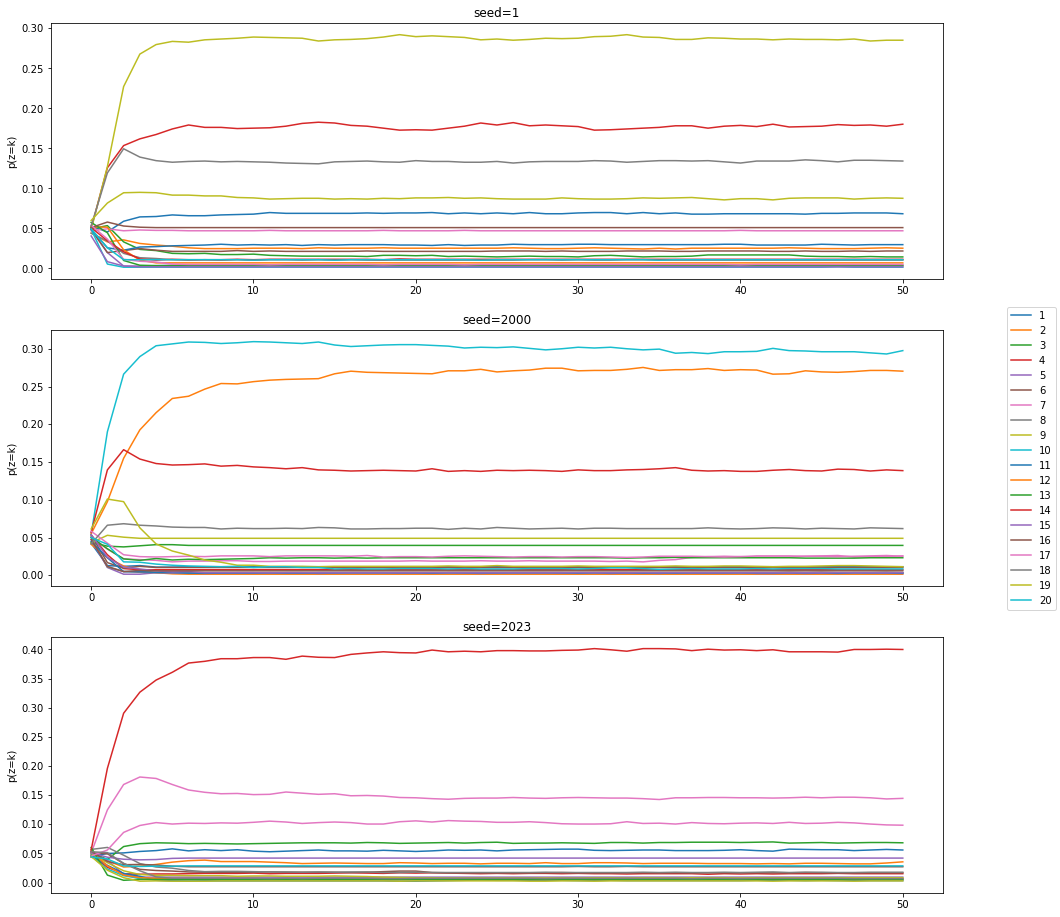

In [38]:
seeds = [1, 2000, 2023]
fig = plt.figure(figsize=(16, 16))
for i, seed in enumerate(seeds):
    perplexity_bbm, swk_bbm, posteriors_bbm, swks_bbm = BMM(A, B, K, alpha, gamma, seed)
    print(perplexity_bbm)
    posterior_counts_bbm = np.vstack(posteriors_bbm) + alpha
    posterior_probs_bbm = []
    plt.subplot(3, 1, i + 1)
    for j in range(51):
        posterior_probs_bbm.append(posterior_counts_bbm[j, :] / np.sum(posterior_counts_bbm[j, :]))
    posterior_probs_bbm = np.vstack(posterior_probs_bbm)
    for i in range(K):
        plt.plot(np.arange(51), posterior_probs_bbm[:, i])
    if i == 2:
        plt.xlabel('iteration')
    plt.title('seed={}'.format(seed))
    plt.ylabel('p(z=k)')
fig.legend(np.arange(K) + 1, loc='right')
plt.savefig('plots/d2.jpg')

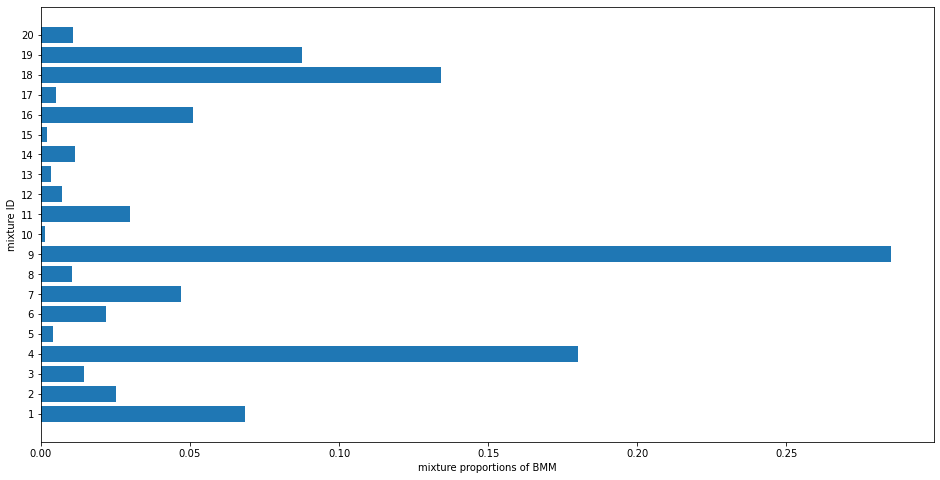

In [34]:
plt.figure(figsize=(16, 8))
plt.barh(np.arange(20)+1, posterior_probs_bbm[-1, :])
plt.ylabel('mixture ID')
plt.yticks(np.arange(20) + 1)
plt.xlabel('mixture proportions of BMM')
plt.savefig('plots/d3.jpg')

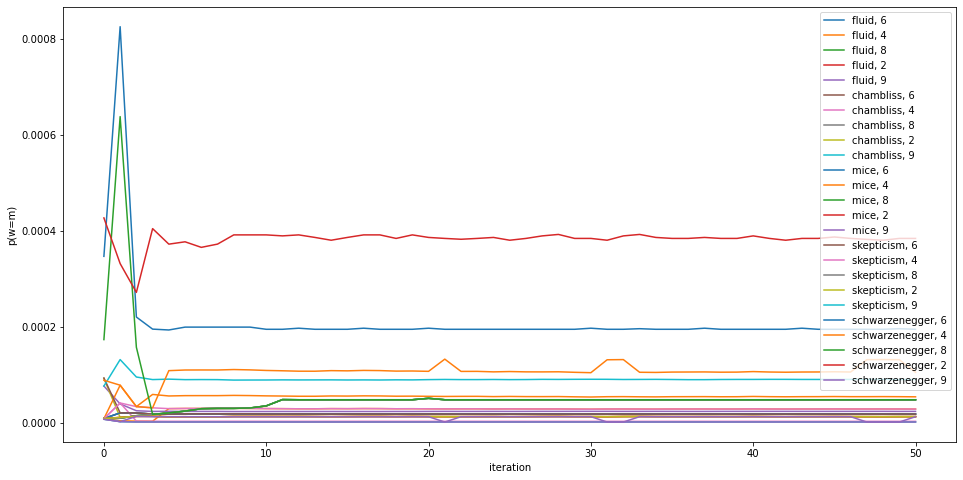

In [12]:
np.random.seed(42)
for i in range(len(swks_bbm)):
    swks_bbm[i] = (swks_bbm[i] + gamma) / np.sum((swks_bbm[i] + gamma), axis=0)
# ind_w = np.arange(5)
# ind_k = np.arange(5)
ind_w = np.random.choice(np.arange(6906), 5, replace=False)
ind_k = np.random.choice(np.arange(20), 5, replace=False)
plt.figure(figsize=(16, 8))
for j in ind_w:
    for k in ind_k:
        tmp = [x[j, k] for x in swks_bbm]
        plt.plot(np.arange(51), tmp)
plt.legend(['{}, {}'.format(V[j], k + 1) for j in ind_w for k in ind_k])
plt.xlabel('iteration')
plt.ylabel('p(w=m)')
plt.savefig('plots/d2.jpg')

# Qe

In [39]:
K = 20
alpha = .1
gamma = .1
perplexity, swk, topic_posteriors, word_entropys = LDA(A, B, K, alpha, gamma)
print('perplexity: {}'.format(perplexity))

  0%|          | 0/50 [00:00<?, ?it/s]

perplexity: [1640.05683153]


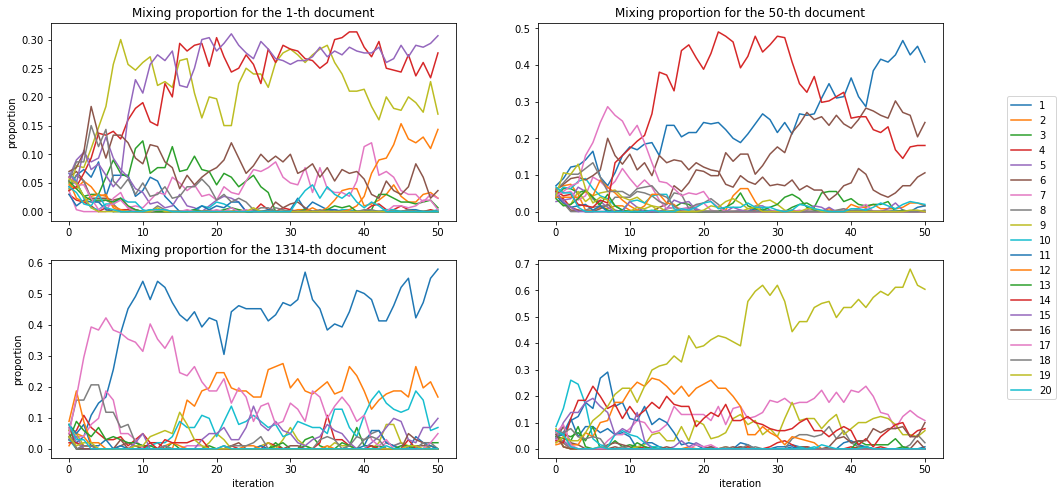

In [64]:
import copy
plt.tight_layout
tp = copy.deepcopy(topic_posteriors)
for t in tp:
    t += alpha
    t /= np.sum(t, axis=0)
def plot_doc(tp, doc_id, alpha=.1):
    doc = np.vstack([i[:, doc_id - 1].flatten() for i in tp])
    for j in range(20):
        plt.plot(np.arange(len(doc)), doc[:, j])
#     plt.legend(np.arange(20) + 1)
    plt.title('Mixing proportion for the {}-th document'.format(doc_id))

def multi_plot(tp):
    fig = plt.figure(figsize=(16, 8))
    plt.subplot(2, 2, 1)
    plot_doc(tp, 1)
    plt.ylabel('proportion')
    plt.subplot(2, 2, 2)
    plot_doc(tp, 50)
    plt.subplot(2, 2, 3)
    plot_doc(tp, 1314)
    plt.ylabel('proportion')
    plt.xlabel('iteration')
    plt.subplot(2, 2, 4)
    plot_doc(tp, 2000)
    plt.xlabel('iteration')
    
#     plt.subplot(4, 2, 5)
    tp_mean = []
#     plt.figure(figsize=(16, 8))
#     for t in tp:
#         tp_mean.append(np.mean(t, axis=1))
#     tp_mean = np.vstack(tp_mean)
#     for i in range(20):
#         plt.plot(np.arange(51), tp_mean[:, i])
    fig.legend(np.arange(20) + 1, loc='right')
multi_plot(tp)
plt.savefig('plots/e1.jpg')

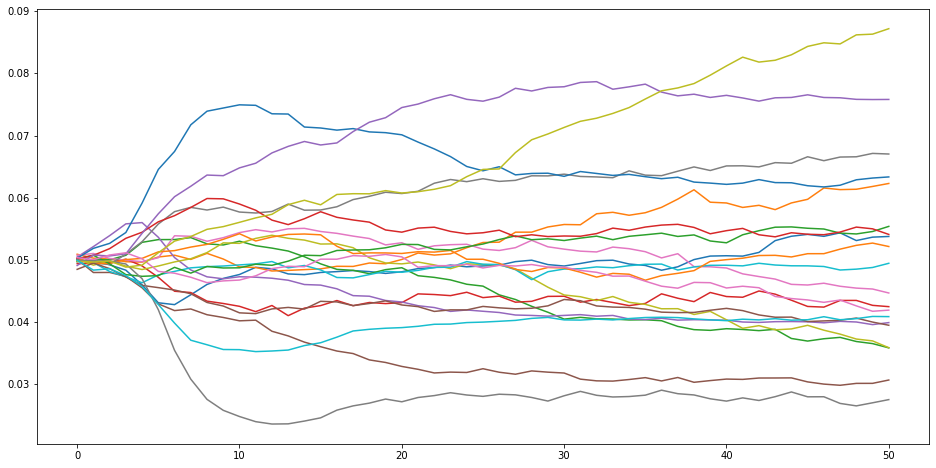

In [55]:
tp_mean = []
plt.figure(figsize=(16, 8))
for t in tp:
    tp_mean.append(np.mean(t, axis=1))
tp_mean = np.vstack(tp_mean)
for i in range(20):
    plt.plot(np.arange(51), tp_mean[:, i])

In [47]:
np.mean(tp[0], axis=1)

1.0

Text(0, 0.5, 'entropy')

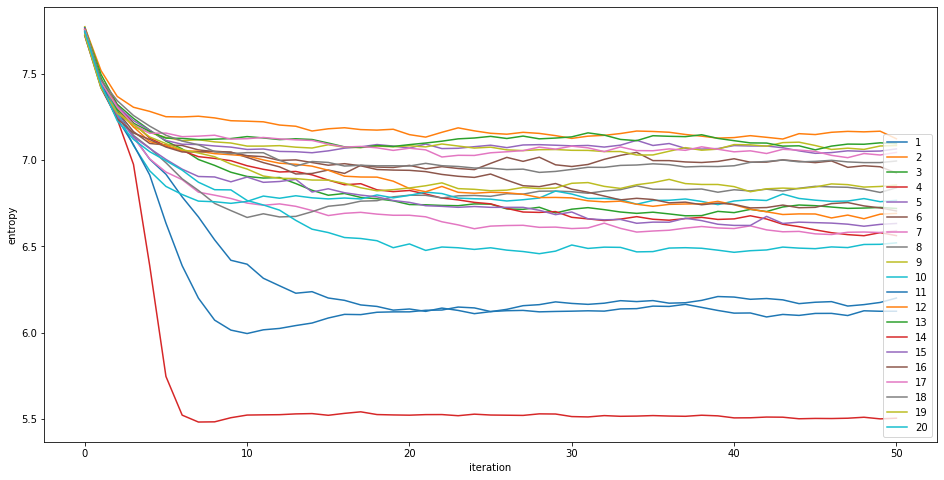

In [15]:
word_entropys = np.vstack(word_entropys)
plt.figure(figsize=(16, 8))
for i in range(K):
    plt.plot(np.arange(51), word_entropys[:, i])
plt.legend(np.arange(K) + 1, loc=4)
plt.xlabel('iteration')
plt.ylabel('entropy')
# plt.savefig('plots/e3.jpg')

In [24]:
def entropy(counts):
    probs = (counts / np.sum(counts, axis=0)).T
    return -np.sum(probs * np.vectorize(lambda x: np.log(x) if x!=0. else 0.)(probs), axis=1)

np.log(6906), entropy(swk), np.argsort(entropy(swk)), np.max(entropy(swk + 0.1))

(8.840145877949938,
 array([6.0148225 , 6.86227539, 6.50038897, 6.25032919, 6.81566089,
        6.49794099, 6.29071037, 6.67842688, 6.85158193, 6.36580386,
        5.87577848, 6.43376388, 6.76193753, 5.34697565, 6.31827806,
        6.3373891 , 6.75371982, 6.77529979, 6.3609    , 6.24131299]),
 array([13, 10,  0, 19,  3,  6, 14, 15, 18,  9, 11,  5,  2,  7, 16, 12, 17,
         4,  8,  1]),
 6.86227538916808)

# Questions
1. Does "uniform multinomial" in question c means "uniform categorical"?

## Office Hour1
1. We use the categorical distribution because we observe a sequence, but we're not using any information about orders of words in this case.
2. How to chose \alpha? alpha=1 would be enough